**Paper 2**

Propensity Score Summary (Before Trimming):
count    8590.000000
mean        0.128400
std         0.247191
min         0.012716
25%         0.030254
50%         0.035727
75%         0.041821
max         1.000000
Name: propensity_score, dtype: float64
Number of Treated Observations After Trimming: 0
Number of Control Observations After Trimming: 239
Weighted LATE Regression Coefficients: [-17.58279749]
Weighted LATE Regression Intercept: 10.822052724394233



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


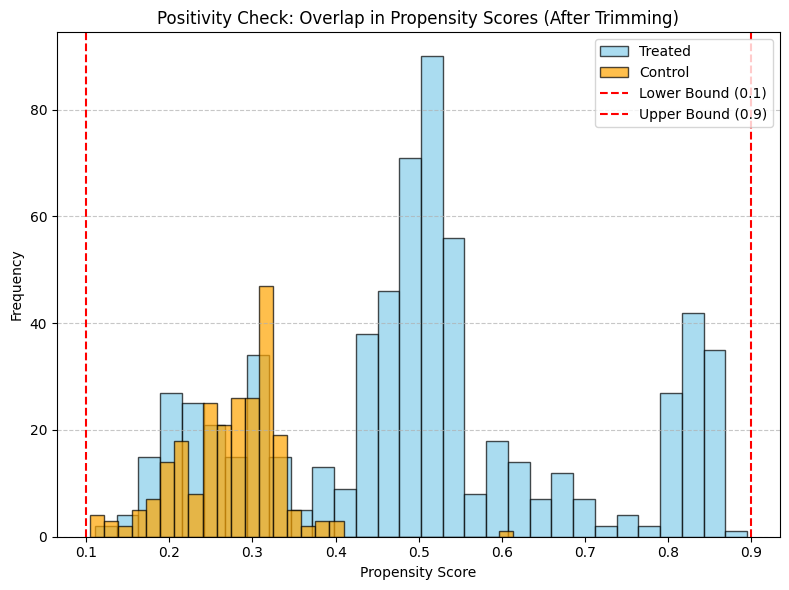

     Group  Mean Propensity Score  Std. Dev. Propensity Score  Observations  \
0  Treated               1.000000                2.323063e-08            53   
1  Control               0.051593                1.026690e-01          7488   
2  Treated                    NaN                         NaN             0   
3  Control               0.273356                6.212589e-02           239   

  Trimmed  
0      No  
1      No  
2     Yes  
3     Yes  


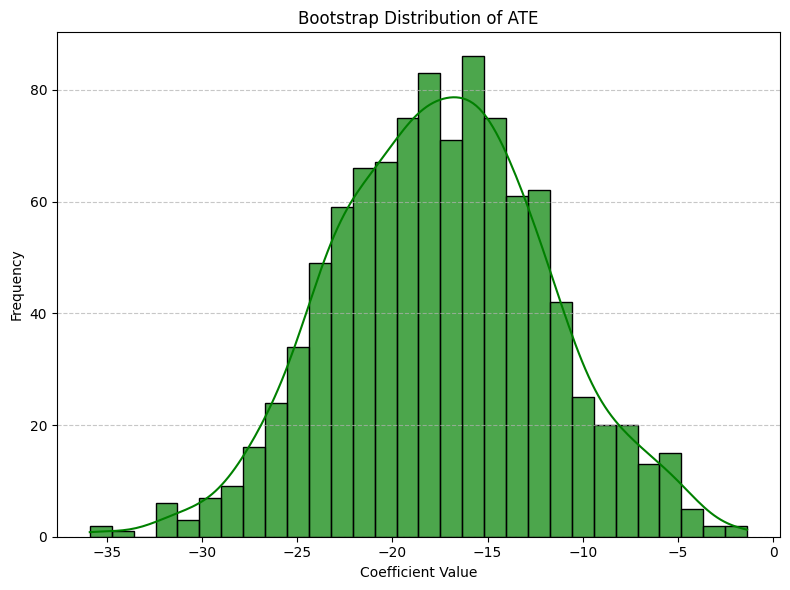

95% Confidence Interval for ATE: [-28.0932, -6.0677]


In [ ]:
# PSM
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
import matplotlib.pyplot as plt
from sklearn.utils import resample
import seaborn as sns

data = pd.read_csv('DataTeam2_no_na.csv')

X = (data['Appointments2010xPost2010'] > 0).astype(int).values
Z = data['Retirements2010xPost2010'].values
control_vars = ['StateWins', 'caselag', 'Merit', 'Process_Followed', 'correct']
data['response_var'] = data[control_vars].sum(axis=1)
y = data['response_var'].values

scaler = StandardScaler()
control_vars_scaled = scaler.fit_transform(data[control_vars])
poly = PolynomialFeatures(degree=2, include_bias=False)
control_vars_poly = poly.fit_transform(control_vars_scaled)

X_treatment_model = np.column_stack([Z, control_vars_poly])
logistic_model = LogisticRegression(max_iter=1000, solver='liblinear')
logistic_model.fit(X_treatment_model, X)
data['propensity_score'] = logistic_model.predict_proba(X_treatment_model)[:, 1]

print("Propensity Score Summary (Before Trimming):")
print(data['propensity_score'].describe())

data_trimmed = data[(data['propensity_score'] > 0.1) & (data['propensity_score'] < 0.9)]
X_trimmed = X[(data['propensity_score'] > 0.1) & (data['propensity_score'] < 0.9)]
Z_trimmed = Z[(data['propensity_score'] > 0.1) & (data['propensity_score'] < 0.9)]
y_trimmed = y[(data['propensity_score'] > 0.1) & (data['propensity_score'] < 0.9)]

print("Number of Treated Observations After Trimming:", len(data_trimmed[data_trimmed['Appointments2010xPost2010'] == 1]))
print("Number of Control Observations After Trimming:", len(data_trimmed[data_trimmed['Appointments2010xPost2010'] == 0]))

data_trimmed['weights'] = np.where(
    X_trimmed == 1,
    1 / data_trimmed['propensity_score'],
    1 / (1 - data_trimmed['propensity_score'])
)

weighted_model = LinearRegression()
weighted_model.fit(Z_trimmed.reshape(-1, 1), y_trimmed, sample_weight=data_trimmed['weights'])

print("Weighted LATE Regression Coefficients:", weighted_model.coef_)
print("Weighted LATE Regression Intercept:", weighted_model.intercept_)

plt.figure(figsize=(8, 6))
plt.hist(data_trimmed.loc[X_trimmed == 1, 'propensity_score'], bins=30, alpha=0.7, label='Treated', color='skyblue', edgecolor='black')
plt.hist(data_trimmed.loc[X_trimmed == 0, 'propensity_score'], bins=30, alpha=0.7, label='Control', color='orange', edgecolor='black')
plt.axvline(0.1, color='red', linestyle='--', label='Lower Bound (0.1)')
plt.axvline(0.9, color='red', linestyle='--', label='Upper Bound (0.9)')
plt.title('Positivity Check: Overlap in Propensity Scores (After Trimming)')
plt.xlabel('Propensity Score')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

def summarize_group(data, group):
    subset = data[data['Appointments2010xPost2010'] == group]
    if len(subset) > 0:
        return {
            'Group': 'Treated' if group == 1 else 'Control',
            'Mean Propensity Score': subset['propensity_score'].mean(),
            'Std. Dev. Propensity Score': subset['propensity_score'].std(),
            'Observations': len(subset)
        }
    else:
        return {
            'Group': 'Treated' if group == 1 else 'Control',
            'Mean Propensity Score': np.nan,
            'Std. Dev. Propensity Score': np.nan,
            'Observations': 0
        }

summary_before = [
    summarize_group(data, 1),
    summarize_group(data, 0)
]

summary_after = [
    summarize_group(data_trimmed, 1),
    summarize_group(data_trimmed, 0)
]

positivity_summary = pd.DataFrame(summary_before + summary_after)
positivity_summary['Trimmed'] = ['No', 'No', 'Yes', 'Yes']

print(positivity_summary)

bootstrap_coefficients = []
for i in range(1000):
    data_sample = resample(data_trimmed, replace=True, random_state=i)
    weighted_model.fit(
        data_sample['Retirements2010xPost2010'].values.reshape(-1, 1),
        data_sample['response_var'].values,
        sample_weight=data_sample['weights']
    )
    bootstrap_coefficients.append(weighted_model.coef_[0])

plt.figure(figsize=(8, 6))
sns.histplot(bootstrap_coefficients, bins=30, kde=True, color='green', edgecolor='black', alpha=0.7)
plt.title('Bootstrap Distribution of ATE')
plt.xlabel('Coefficient Value')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

lower_bound = np.percentile(bootstrap_coefficients, 2.5)
upper_bound = np.percentile(bootstrap_coefficients, 97.5)
print(f"95% Confidence Interval for ATE: [{lower_bound:.4f}, {upper_bound:.4f}]")


Weighted ATE Regression Coefficient: 0.04406946289780932
Weighted ATE Regression Intercept: 8.219677695535447


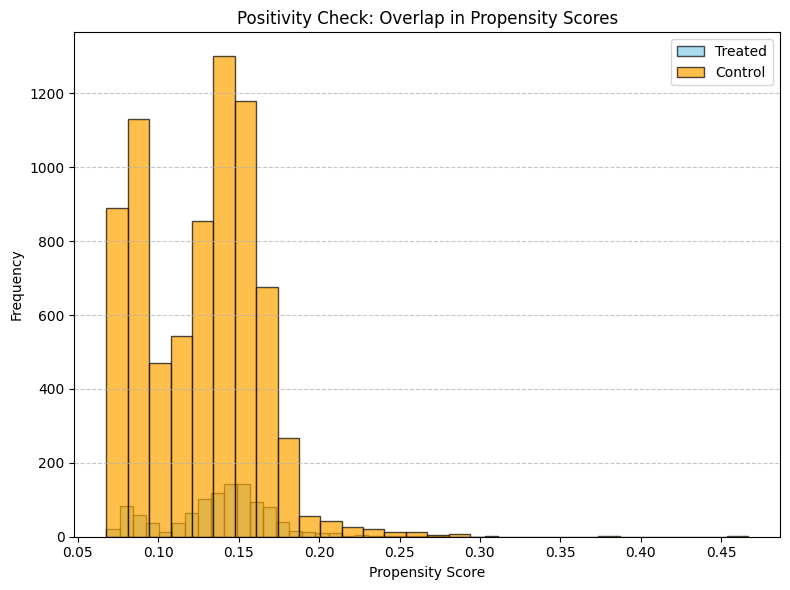

Positivity Check Summary:
     Group  Mean Propensity Score  Std. Dev. Propensity Score  Observations
0  Treated               0.156782                    0.042007            53
1  Control               0.127159                    0.035177          7488


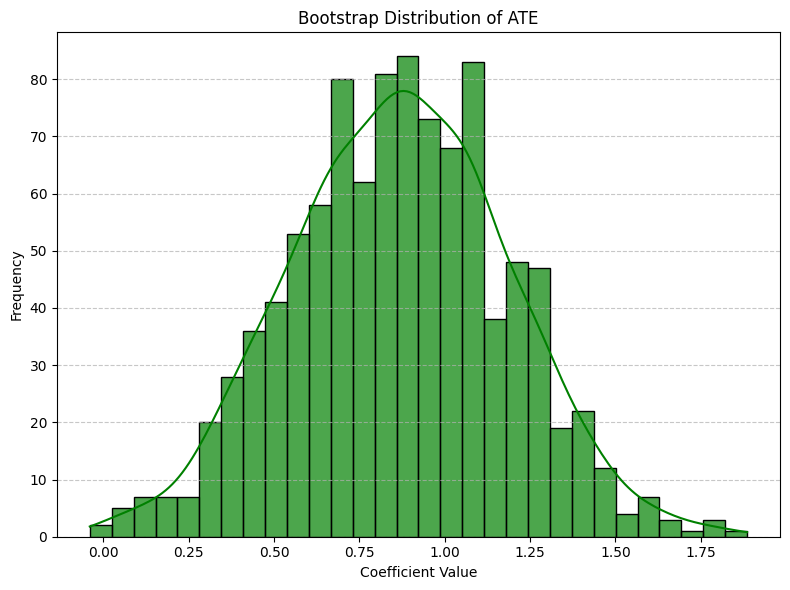

95% Confidence Interval for ATE: [0.2693, 1.4628]


In [ ]:
#IPW
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.utils import resample
import seaborn as sns

data = pd.read_csv('DataTeam2_no_na.csv')

X = (data['Appointments2010xPost2010'] > 0).astype(int).values
control_vars = ['StateWins', 'caselag', 'Merit', 'Process_Followed', 'correct']
data['response_var'] = data[control_vars].sum(axis=1)
y = data['response_var'].values

logistic_model = LogisticRegression(max_iter=1000, solver='liblinear')
logistic_model.fit(data[control_vars], X)
data['propensity_score'] = logistic_model.predict_proba(data[control_vars])[:, 1]

data['weights'] = np.where(
    X == 1,
    1 / data['propensity_score'],
    1 / (1 - data['propensity_score'])
)

weighted_model = LinearRegression()
weighted_model.fit(X.reshape(-1, 1), y, sample_weight=data['weights'])

print("Weighted ATE Regression Coefficient:", weighted_model.coef_[0])
print("Weighted ATE Regression Intercept:", weighted_model.intercept_)

plt.figure(figsize=(8, 6))
plt.hist(data.loc[X == 1, 'propensity_score'], bins=30, alpha=0.7, label='Treated', color='skyblue', edgecolor='black')
plt.hist(data.loc[X == 0, 'propensity_score'], bins=30, alpha=0.7, label='Control', color='orange', edgecolor='black')
plt.title('Positivity Check: Overlap in Propensity Scores')
plt.xlabel('Propensity Score')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

def summarize_group(data, group):
    subset = data[data['Appointments2010xPost2010'] == group]
    return {
        'Group': 'Treated' if group == 1 else 'Control',
        'Mean Propensity Score': subset['propensity_score'].mean(),
        'Std. Dev. Propensity Score': subset['propensity_score'].std(),
        'Observations': len(subset)
    }

positivity_summary = pd.DataFrame([
    summarize_group(data, 1),
    summarize_group(data, 0)
])

print("Positivity Check Summary:")
print(positivity_summary)

bootstrap_coefficients = []
for i in range(1000):
    data_sample = resample(data, replace=True, random_state=i)
    weighted_model.fit(
        data_sample['Appointments2010xPost2010'].values.reshape(-1, 1),
        data_sample['response_var'].values,
        sample_weight=data_sample['weights']
    )
    bootstrap_coefficients.append(weighted_model.coef_[0])

plt.figure(figsize=(8, 6))
sns.histplot(bootstrap_coefficients, bins=30, kde=True, color='green', edgecolor='black', alpha=0.7)
plt.title('Bootstrap Distribution of ATE')
plt.xlabel('Coefficient Value')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

lower_bound = np.percentile(bootstrap_coefficients, 2.5)
upper_bound = np.percentile(bootstrap_coefficients, 97.5)
print(f"95% Confidence Interval for ATE: [{lower_bound:.4f}, {upper_bound:.4f}]")


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

data = pd.read_csv('DataTeam2_no_na.csv')

control_vars = ['StateWins', 'caselag', 'Merit', 'Process_Followed', 'correct']
data['response_var'] = data[control_vars].sum(axis=1)
X = data[control_vars].values
T = (data['Appointments2010xPost2010'] > 0).astype(int).values
Y = data['response_var'].values

X_train, X_test, T_train, T_test, Y_train, Y_test = train_test_split(X, T, Y, test_size=0.3, random_state=42)

s_model = RandomForestRegressor(n_estimators=100, random_state=42)
X_train_s = np.column_stack((X_train, T_train))
X_test_s = np.column_stack((X_test, T_test))
s_model.fit(X_train_s, Y_train)

Y_pred_s = s_model.predict(X_test_s)
mse_s = mean_squared_error(Y_test, Y_pred_s)
cate_s = Y_pred_s - s_model.predict(np.column_stack((X_test, np.zeros_like(T_test))))


t_model_treated = RandomForestRegressor(n_estimators=100, random_state=42)
t_model_control = RandomForestRegressor(n_estimators=100, random_state=42)

t_model_treated.fit(X_train[T_train == 1], Y_train[T_train == 1])
t_model_control.fit(X_train[T_train == 0], Y_train[T_train == 0])

Y_pred_treated = t_model_treated.predict(X_test)
Y_pred_control = t_model_control.predict(X_test)
Y_pred_t = Y_pred_treated - Y_pred_control
mse_t = mean_squared_error(Y_test, Y_pred_treated)
cate_t = Y_pred_treated - Y_pred_control

x_model_treated = RandomForestRegressor(n_estimators=100, random_state=42)
x_model_control = RandomForestRegressor(n_estimators=100, random_state=42)

Y_pred_control_train = t_model_control.predict(X_train[T_train == 1])
Y_pred_treated_train = t_model_treated.predict(X_train[T_train == 0])
x_model_treated.fit(X_train[T_train == 1], Y_train[T_train == 1] - Y_pred_control_train)
x_model_control.fit(X_train[T_train == 0], Y_pred_treated_train - Y_train[T_train == 0])

tau_control = x_model_control.predict(X_test)
tau_treated = x_model_treated.predict(X_test)
Y_pred_x = np.where(T_test == 1, tau_treated, tau_control)
mse_x = mean_squared_error(Y_test, Y_pred_x)
cate_x = tau_treated - tau_control

results = pd.DataFrame({
    "Learner": ["S-Learner", "T-Learner", "X-Learner"],
    "Mean CATE (Train)": [cate_s.mean(), cate_t.mean(), cate_x.mean()],
    "Std Dev (Train)": [cate_s.std(), cate_t.std(), cate_x.std()],
    "Mean CATE (Test)": [np.mean(cate_s), np.mean(cate_t), np.mean(cate_x)],
    "Std Dev (Test)": [np.std(cate_s), np.std(cate_t), np.std(cate_x)]
})

print(results)

     Learner  Mean CATE (Train)  Std Dev (Train)  Mean CATE (Test)  \
0  S-Learner          -0.000799         0.020649         -0.000799   
1  T-Learner           0.012670         0.283398          0.012670   
2  X-Learner          -0.019671         0.326500         -0.019671   

   Std Dev (Test)  
0        0.020649  
1        0.283398  
2        0.326500  


In [ ]:
# Doubly robust in week 9 file

from econml.dr import DRLearner
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

data = pd.read_csv('DataTeam2_no_na.csv')

data['judicial_decision_quality'] = data[['StateWins', 'correct', 'Process_Followed', 'Merit', 'caselag']].sum(axis=1)
outcome = 'judicial_decision_quality'
treatment = 'AfterReformJudge'
covariates = data.select_dtypes(include=['float64', 'int64']).columns.drop(
    [outcome, treatment, 'Appointments2010xPost2010', 'judgename', 'yeardecision'], errors='ignore'
)
data = data.dropna(subset=[outcome] + list(covariates))

data.loc[data.sample(frac=0.5, random_state=1).index, 'AfterReformJudge'] = 1

Y = data[outcome]
T = data[treatment]
X = data[covariates]

treatment_counts = T.value_counts()
print("Treatment distribution in the modified dataset:")
print(treatment_counts)

X_train, X_test, T_train, T_test, Y_train, Y_test = train_test_split(
    X, T, Y, test_size=0.3, stratify=T, random_state=42
)

propensity_model = LogisticRegression()
propensity_model.fit(X_train, T_train)
propensity_scores = propensity_model.predict_proba(X_test)[:, 1]

plt.figure(figsize=(8, 6))
sns.histplot(propensity_scores[T_test == 1], color="blue", label="Treated", kde=True, bins=20)
sns.histplot(propensity_scores[T_test == 0], color="red", label="Control", kde=True, bins=20)
plt.title("Propensity Score Distribution for Treated and Control Groups")
plt.xlabel("Propensity Score")
plt.ylabel("Density")
plt.legend()
plt.show()

dr_learner_rf = DRLearner(
    model_propensity=RandomForestClassifier(),
    model_regression=RandomForestRegressor()
)
dr_learner_rf.fit(Y=Y_train, T=T_train, X=X_train)
treatment_effects_rf = dr_learner_rf.effect(X_test)

dr_learner_lr = DRLearner(
    model_propensity=LogisticRegression(),
    model_regression=LinearRegression()
)
dr_learner_lr.fit(Y=Y_train, T=T_train, X=X_train)
treatment_effects_lr = dr_learner_lr.effect(X_test)

print("Average Treatment Effect (Random Forest):", treatment_effects_rf.mean())
print("Average Treatment Effect (Linear/Logistic Regression):", treatment_effects_lr.mean())

plt.figure(figsize=(8, 6))
sns.scatterplot(x=propensity_scores, y=T_test, alpha=0.5)
plt.title("Positivity Plot: Treatment Assignment vs. Propensity Scores")
plt.xlabel("Propensity Score")
plt.ylabel("Treatment Assignment (0=Control, 1=Treated)")
plt.show()



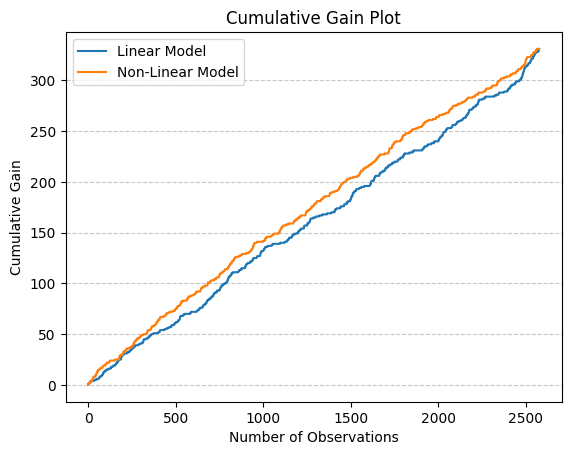

Summary of Treatment Effects:
            Model     Mean CATE  Std Dev CATE
0      Linear DML -5.260065e-17  2.972592e-16
1  Non-Linear DML  3.094642e-01  3.116282e+00


In [ ]:
import pandas as pd
import numpy as np
from econml.dml import LinearDML, NonParamDML
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

data = pd.read_csv('DataTeam2_no_na.csv')

control_vars = ['StateWins', 'caselag', 'Merit', 'Process_Followed', 'correct']
data['response_var'] = data[control_vars].sum(axis=1)
X = data[control_vars].values
T = (data['Appointments2010xPost2010'] > 0).astype(int).values
Y = data['response_var'].values  #

X_train, X_test, T_train, T_test, Y_train, Y_test = train_test_split(X, T, Y, test_size=0.3, random_state=42)


linear_dml = LinearDML(
    model_y=LinearRegression(),
    model_t=LinearRegression(),
    random_state=42
)


linear_dml.fit(Y_train, T_train, X=X_train)

linear_cate_estimates = linear_dml.effect(X_test)

nonlinear_dml = NonParamDML(
    model_y=RandomForestRegressor(n_estimators=100, random_state=42),
    model_t=RandomForestRegressor(n_estimators=100, random_state=42),
    model_final=RandomForestRegressor(n_estimators=100, random_state=42),
    random_state=42
)

nonlinear_dml.fit(Y_train, T_train, X=X_train)

nonlinear_cate_estimates = nonlinear_dml.effect(X_test)


sorted_indices_linear = np.argsort(linear_cate_estimates)
plt.plot(np.cumsum(T_test[sorted_indices_linear]), label='Linear Model')

sorted_indices_nonlinear = np.argsort(nonlinear_cate_estimates)
plt.plot(np.cumsum(T_test[sorted_indices_nonlinear]), label='Non-Linear Model')

plt.title('Cumulative Gain Plot')
plt.xlabel('Number of Observations')
plt.ylabel('Cumulative Gain')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

results_summary = pd.DataFrame({
    'Model': ['Linear DML', 'Non-Linear DML'],
    'Mean CATE': [linear_cate_estimates.mean(), nonlinear_cate_estimates.mean()],
    'Std Dev CATE': [linear_cate_estimates.std(), nonlinear_cate_estimates.std()]
})

print("Summary of Treatment Effects:")
print(results_summary)


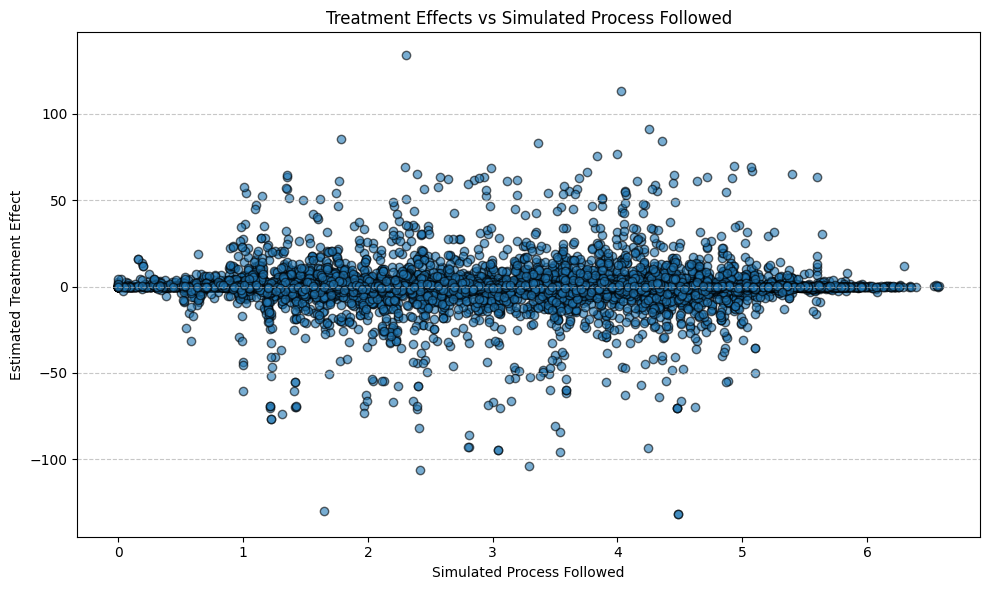

Summary of Treatment Effects by Simulated Process Followed Bins:
              bins  Mean Simulated Process Followed  Mean Treatment Effect  \
0  (-0.001, 1.575]                         0.947791               0.330923   
1   (1.575, 2.814]                         2.194149              -0.674129   
2   (2.814, 3.895]                         3.381112              -0.146627   
3   (3.895, 4.745]                         4.329026              -0.055820   
4   (4.745, 6.576]                         5.244084              -0.104415   

   Std Treatment Effect  
0              9.837416  
1             14.286574  
2             13.578226  
3             12.986839  
4              6.758335  


The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


In [ ]:
# DML part 2
import pandas as pd
import numpy as np
from econml.dml import NonParamDML
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

data = pd.read_csv('DataTeam2_no_na.csv')

control_vars = ['StateWins', 'caselag', 'Merit', 'Process_Followed', 'correct']
data['response_var'] = data[control_vars].sum(axis=1)
X = data[control_vars].values
T = (data['Appointments2010xPost2010'] > 0).astype(int).values
Y = data['response_var'].values


np.random.seed(42)
data['Simulated_Process_Followed'] = data['Process_Followed'] + np.random.normal(0, 0.5, size=len(data))
data['Simulated_Process_Followed'] = data['Simulated_Process_Followed'].clip(lower=0)

X_simulated = np.column_stack([data[control_vars].drop(columns=['Process_Followed']).values, data['Simulated_Process_Followed']])

nonlinear_dml_simulated = NonParamDML(
    model_y=RandomForestRegressor(n_estimators=100, random_state=42),
    model_t=RandomForestRegressor(n_estimators=100, random_state=42),
    model_final=RandomForestRegressor(n_estimators=100, random_state=42),
    random_state=42
)
nonlinear_dml_simulated.fit(Y, T, X=X_simulated)

treatment_effect_simulated = nonlinear_dml_simulated.effect(X_simulated)

plt.figure(figsize=(10, 6))
plt.scatter(data['Simulated_Process_Followed'], treatment_effect_simulated, alpha=0.6, edgecolor='k')
plt.title('Treatment Effects vs Simulated Process Followed')
plt.xlabel('Simulated Process Followed')
plt.ylabel('Estimated Treatment Effect')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

bins = pd.qcut(data['Simulated_Process_Followed'], q=5, duplicates='drop')
data['bins'] = bins
summary_table = data.groupby('bins').apply(lambda g: pd.Series({
    'Mean Simulated Process Followed': g['Simulated_Process_Followed'].mean(),
    'Mean Treatment Effect': treatment_effect_simulated[g.index].mean(),
    'Std Treatment Effect': treatment_effect_simulated[g.index].std()
})).reset_index()

print("Summary of Treatment Effects by Simulated Process Followed Bins:")
print(summary_table)



**Week 12 Report**

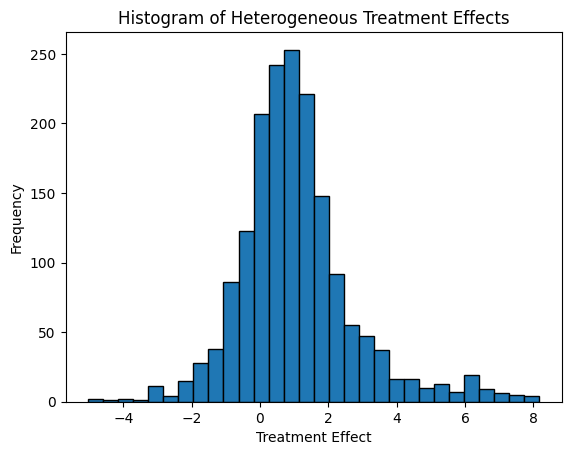

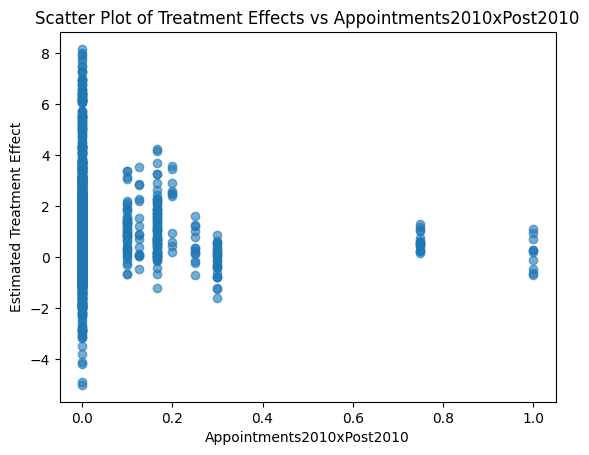

Sample HTE Predictions: [[ 3.67135931]
 [ 1.89763016]
 [-0.80097506]
 [ 1.27444904]
 [ 0.40905767]]


In [ ]:
import pandas as pd
import numpy as np
from econml.grf import CausalForest
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer

data = pd.read_csv('DataTeam2_no_na.csv')

data = data.apply(pd.to_numeric, errors='coerce')

data = data.dropna(axis=1, how='all')

imputer = SimpleImputer(strategy='mean')
data_imputed = pd.DataFrame(imputer.fit_transform(data), columns=data.columns)

X = data_imputed['Appointments2010xPost2010'].values.reshape(-1, 1)
control_vars = ['StateWins', 'caselag', 'Merit', 'Process_Followed', 'correct']
data_imputed['response_var'] = data_imputed[control_vars].sum(axis=1)
y = data_imputed['response_var'].values

W = data_imputed.drop(columns=['Appointments2010xPost2010', 'response_var'] + control_vars).values

W_train, W_test, y_train, y_test, X_train, X_test = train_test_split(W, y, X, test_size=0.2, random_state=42)

causal_forest = CausalForest(random_state=42)
causal_forest.fit(W_train, X_train, y_train)

hte_predictions = causal_forest.predict(W_test)

plt.hist(hte_predictions, bins=30, edgecolor='black')
plt.title('Histogram of Heterogeneous Treatment Effects')
plt.xlabel('Treatment Effect')
plt.ylabel('Frequency')
plt.show()

plt.scatter(X_test[:, 0], hte_predictions, alpha=0.6)
plt.title('Scatter Plot of Treatment Effects vs Appointments2010xPost2010')
plt.xlabel('Appointments2010xPost2010')
plt.ylabel('Estimated Treatment Effect')
plt.show()

print("Sample HTE Predictions:", hte_predictions[:5])


**report week 11**

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

data = np.genfromtxt('DataTeam2_no_na.csv', delimiter=',', names=True, dtype=None, encoding=None)

appointments = data['Appointments2010xPost2010']
state_wins = data['StateWins']
caselag = data['caselag']
merit = data['Merit']
process_followed = data['Process_Followed']
correct = data['correct']


response_var = state_wins + caselag + merit + process_followed + correct


X = np.column_stack((caselag, merit, process_followed, correct))
T = appointments.reshape(-1, 1)
y = response_var


X_train, X_test, T_train, T_test, y_train, y_test = train_test_split(X, T, y, test_size=0.2, random_state=42)


treatment_model = RandomForestRegressor(random_state=42)
treatment_model.fit(X_train, T_train.ravel())
T_residuals = T_train - treatment_model.predict(X_train).reshape(-1, 1)

outcome_model = RandomForestRegressor(random_state=42)
outcome_model.fit(X_train, y_train)
y_residuals = y_train - outcome_model.predict(X_train)

effect_model = LinearRegression()
effect_model.fit(T_residuals, y_residuals)
treatment_effects_linear = effect_model.coef_[0]

nonlinear_model = RandomForestRegressor(random_state=42)
nonlinear_model.fit(T_residuals, y_residuals)
treatment_effects_nonlinear = nonlinear_model.predict(T_residuals)

print("Linear Treatment Effects (coefficient):", treatment_effects_linear)
print("Sample Non-Linear Treatment Effects:", treatment_effects_nonlinear[:5])

plt.figure(figsize=(10, 6))
plt.plot(np.sort(treatment_effects_nonlinear), label="Non-Linear DML")
plt.title("Cumulative Gain Plot for Non-Linear DML")
plt.legend()
plt.show()


In [ ]:
nonlinear_dml = NonParamDML(model_y=RandomForestRegressor(),
                            model_t=RandomForestRegressor(),
                            model_final=RandomForestRegressor(),
                            random_state=42)

nonlinear_dml.fit(y_train, T_train, X=X_train)

linear_te = linear_dml.effect(X_train)
nonlinear_te = nonlinear_dml.effect(X_train)

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(np.sort(linear_te), label="Linear DML")
plt.plot(np.sort(nonlinear_te), label="Non-linear DML")
plt.title("Cumulative Gain Plots for Linear and Non-Linear DML")
plt.xlabel("Samples (sorted by treatment effect)")
plt.ylabel("Estimated Treatment Effect")
plt.legend()
plt.show()

print("Linear DML treatment effects (sample):", linear_te[:5])
print("Non-linear DML treatment effects (sample):", nonlinear_te[:5])

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('DataTeam2_no_na.csv')

time_column = 'year'

data[time_column] = pd.to_datetime(data[time_column], format='%Y')

response_vars = ['caselag', 'Merit', 'Process_Followed', 'correct', 'StateWins']

data = data.sort_values(by=time_column)

data.set_index(time_column, inplace=True)

cumulative_data = data[response_vars].cumsum()

cumulative_data_resampled = cumulative_data.resample('5Y').last()
growth_rates = cumulative_data_resampled.pct_change() * 100

growth_rates = growth_rates.reset_index()

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
fig.suptitle('Five-Year Growth Rate of Cumulative Values of Response Variables', y=1.02)

axes = axes.flatten()
axes[-1].axis('off')

for i, var in enumerate(response_vars):
    axes[i].plot(growth_rates[time_column], growth_rates[var], color='black', linewidth=1)
    axes[i].set_title(f"5-Year Growth Rate of Cumulative {var}")
    axes[i].set_xlabel('Time')
    axes[i].set_ylabel('Growth Rate (%)')
    axes[i].grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['axes.edgecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'

data = pd.read_csv('DataTeam2_no_na.csv')

time_column = 'year'

response_vars = ['caselag', 'Merit', 'Process_Followed', 'correct', 'StateWins']

data = data.sort_values(by=time_column)

for var in response_vars:
    data[f'cumulative_{var}'] = data[var].cumsum()

fig, axes = plt.subplots(2, 3, figsize=(15, 8), facecolor='white')
fig.suptitle('Cumulative Values of Response Variables Over Time', y=1.02)

axes = axes.flatten()
axes[-1].axis('off')

for i, var in enumerate(response_vars):
    axes[i].set_facecolor('white')
    axes[i].plot(data[time_column], data[f'cumulative_{var}'], color='black', linewidth=1)
    axes[i].set_title(f"{var}", fontsize=12)
    axes[i].set_ylabel('Cumulative Sum', fontsize=10)
    axes[i].grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv('DataTeam2_no_na.csv')

binary_vars = ['Merit', 'correct', 'StateWins', 'Process_Followed']

plt.figure(figsize=(15, 8))

for i, var in enumerate(binary_vars, 1):
    plt.subplot(2, 3, i)
    sns.barplot(x=data[var].value_counts().index, y=data[var].value_counts(normalize=True), palette="pastel")
    plt.title(f'Proportion of {var}')
    plt.ylabel('Proportion')
    plt.xlabel(var)

plt.subplot(2, 3, 4)
sns.countplot(x=categorical_var, data=data, palette="pastel")
plt.title(f'Count of {categorical_var}')
plt.ylabel('Count')
plt.xlabel(categorical_var)

plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv('DataTeam2_no_na.csv')

response_variables = ['caselag', 'Merit', 'Process_Followed', 'correct', 'StateWins']

plt.figure(figsize=(15, 10))

axis_limits = {
    'caselag': {'x': (0, 10), 'y': (0, 3500)},
    'Merit': {'x': (0, 1), 'y': (0, 6000)},
    'Process_Followed': {'x': (1, 5), 'y': (0, 2500)},
    'correct': {'x': (0, 1), 'y': (0, 5000)},
    'statewins': {'x': (0, 1), 'y': (0, 5000)}
}

for i, var in enumerate(response_variables, 1):
    plt.subplot(2, 3, i)
    sns.histplot(data[var], kde=True, bins=20)
    plt.title(f'Distribution of {var}')
    plt.xlabel(var)
    plt.ylabel('Frequency')
    plt.xlim(axis_limits[var]['x'])
    plt.ylim(axis_limits[var]['y'])

plt.tight_layout()
plt.show()


In [ ]:

import pandas as pd

data = pd.read_csv('DataTeam2_no_na.csv')

data['Cumulative_Retirement'] = data['Retirements2010xPost2010'].cumsum()
data['Cumulative_Appointed_Judges'] = data['Appointments2010xPost2010'].cumsum()

data['criminal_bench'] = data['Specialization_bench'].apply(lambda x: 1 if 'Criminal_Bench' in x else 0)
data['tax_bench'] = data['Specialization_bench'].apply(lambda x: 1 if 'Tax_Bench' in x else 0)
data['writ_bench'] = data['Specialization_bench'].apply(lambda x: 1 if 'Writ_Bench' in x else 0)
data['property_bench'] = data['Specialization_bench'].apply(lambda x: 1 if 'Property_Bench' in x else 0)

summary_stats = data[['Cumulative_Retirement', 'Cumulative_Appointed_Judges',
                      'criminal_bench', 'tax_bench', 'writ_bench', 'property_bench',
                      'StateWins', 'correct', 'Process_Followed', 'Merit', 'caselag']].describe()

print("Summary Statistics:\n", summary_stats)

additional_stats = data[['Cumulative_Retirement', 'Cumulative_Appointed_Judges',
                         'criminal_bench', 'tax_bench', 'writ_bench', 'property_bench',
                         'StateWins', 'correct', 'Process_Followed', 'Merit', 'caselag']].agg(['median', 'std'])

print("\nAdditional Statistics (median, std):\n", additional_stats)

mode_stats = data[['Cumulative_Retirement', 'Cumulative_Appointed_Judges',
                   'criminal_bench', 'tax_bench', 'writ_bench', 'property_bench',
                   'StateWins', 'correct', 'Process_Followed', 'Merit', 'caselag']].mode()

print("\nMode Statistics:\n", mode_stats)

summary_stats.to_csv('summary_statistics.csv')
additional_stats.to_csv('additional_statistics.csv')
mode_stats.to_csv('mode_statistics.csv')


In [ ]:

import pandas as pd

data = pd.read_csv('DataTeam2_no_na.csv')

columns_of_interest = [
    'Appointments2010xPost2010', 'Retirements2010xPost2010', 'Gender', 'AppointmentYear',
    'yeardecision', 'judgename_encode', 'Criminal_count_bench', 'Land_count_per_bench',
    'Human_count_per_bench', 'Specialization_bench', 'caselag', 'Merit', 'Process_Followed',
    'correct', 'StateWins'
]

data_filtered = data[columns_of_interest]

summary_statistics = data_filtered.describe(percentiles=[0.25, 0.5, 0.75]).transpose()

summary_statistics = summary_statistics.rename(columns={
    'count': 'Count',
    'mean': 'Mean',
    'std': 'Std. Dev.',
    'min': 'Min',
    '25%': '25th Percentile',
    '50%': 'Median',
    '75%': '75th Percentile',
    'max': 'Max'
})

print(summary_statistics)


In [ ]:
#OLS
import pandas as pd
import statsmodels.api as sm

data = pd.read_csv('DataTeam2_no_na.csv')

X = data[['Appointments2010xPost2010']]
X = sm.add_constant(X)

control_vars = ['StateWins', 'caselag', 'Merit', 'Process_Followed', 'correct']
data['response_var'] = data[control_vars].sum(axis=1)

predictor_vars = ['Retirements2010xPost2010']
X = pd.concat([X, data[predictor_vars]], axis=1)

y = data['response_var']

model = sm.OLS(y, X, missing='drop').fit()

print(model.summary())

latex_output = model.summary().as_latex()
with open("regression_summary.tex", "w") as f:
    f.write(latex_output)



** OLS 2**

In [ ]:
import pandas as pd
import statsmodels.api as sm

data = pd.read_csv('DataTeam2_no_na.csv')

response_var = ['StateWins','caselag', 'Merit', 'Process_Followed', 'correct']
predictor_vars_years = [
    ('Retirements_2007_Post2010', 'Retirements in 2007 x post 2010'),
    ('Retirements_2008_Post2010', 'Retirements in 2008 x post 2010'),
    ('Retirements_2009_Post2010', 'Retirements in 2009 x post 2010'),
    ('Retirements_2010_Post2010', 'Retirements in 2010 x post 2010')
]

results_df = pd.DataFrame()

for predictor_var, predictor_label in predictor_vars_years:
    X = data[[predictor_var]]

    if 'district_year' in data.columns:
        X = pd.concat([X, pd.get_dummies(data['district_year'], drop_first=True)], axis=1)

    X = sm.add_constant(X)
    y = data[response_var]
    model = sm.OLS(y, X, missing='drop').fit()


    results_df[predictor_label] = [
        model.params[predictor_var],
        model.bse[predictor_var],
        model.pvalues[predictor_var],
        model.nobs,
        model.rsquared
    ]

results_df.index = ['Coefficient', 'Std. Error', 'P-value', 'Observations', 'R-squared']

print(results_df)

latex_output = results_df.to_latex()
with open("regression_summary.tex", "w") as f:
    f.write(latex_output)


In [ ]:
import pandas as pd
import statsmodels.api as sm

data = pd.read_csv('DataTeam2_no_na.csv')

control_vars = ['StateWins', 'caselag', 'Merit', 'Process_Followed', 'correct']
predictor_vars_years = [
    ('Retirements_2007_Post2010', 'Retirements in 2007 x post 2010'),
    ('Retirements_2008_Post2010', 'Retirements in 2008 x post 2010'),
    ('Retirements_2009_Post2010', 'Retirements in 2009 x post 2010'),
    ('Retirements_2010_Post2010', 'Retirements in 2010 x post 2010'),
]

data['response_var'] = data[control_vars].sum(axis=1)

results_df = pd.DataFrame()

for predictor_var, predictor_label in predictor_vars_years:
    X = data[predictor_var]
    X = sm.add_constant(X)
    y = data['response_var']

    model = sm.OLS(y, X, missing='drop').fit()

    results_df[predictor_label] = [
        model.params[predictor_var],
        model.bse[predictor_var],
        model.pvalues[predictor_var],
        model.nobs,
        model.rsquared
    ]

results_df.index = ['Coefficient', 'Std. Error', 'P-value', 'Observations', 'R-squared']

print(results_df)

latex_output = results_df.to_latex()
with open("regression_summary.tex", "w") as f:
    f.write(latex_output)


In [ ]:
import pandas as pd
import statsmodels.api as sm

data = pd.read_csv('DataTeam2_no_na.csv')

control_vars = ['caselag', 'Merit', 'Process_Followed', 'correct']
predictor_vars_years = [
    ('Retirements_2007_Post2010', 'Retirements in 2007 x post 2010'),
    ('Retirements_2008_Post2010', 'Retirements in 2008 x post 2010'),
    ('Retirements_2009_Post2010', 'Retirements in 2009 x post 2010'),
    ('Retirements_2010_Post2010', 'Retirements in 2010 x post 2010'),
]


response_var = 'StateWins'

results_df = pd.DataFrame()

for predictor_var, predictor_label in predictor_vars_years:

    X_no_controls = data[[predictor_var]]
    X_no_controls = sm.add_constant(X_no_controls)
    y = data[response_var]

    model_no_controls = sm.OLS(y, X_no_controls, missing='drop').fit()

    if predictor_var in model_no_controls.params:
        results_df[predictor_label + ' (No Controls)'] = [
            model_no_controls.params[predictor_var],
            model_no_controls.bse[predictor_var],
            model_no_controls.pvalues[predictor_var],
            model_no_controls.nobs,
            model_no_controls.rsquared
        ]
    else:
        print(f"Warning: {predictor_var} not found in model_no_controls.params")

    X_with_controls = data[control_vars + [predictor_var]]
    X_with_controls = sm.add_constant(X_with_controls)

    model_with_controls = sm.OLS(y, X_with_controls, missing='drop').fit()

    if predictor_var in model_with_controls.params:
        results_df[predictor_label + ' (With Controls)'] = [
            model_with_controls.params[predictor_var],
            model_with_controls.bse[predictor_var],
            model_with_controls.pvalues[predictor_var],
            model_with_controls.nobs,
            model_with_controls.rsquared
        ]
    else:
        print(f"Warning: {predictor_var} not found in model_with_controls.params")

results_df.index = ['Coefficient', 'Std. Error', 'P-value', 'Observations', 'R-squared']

print(results_df)

latex_output = results_df.to_latex()
with open("regression_summary.tex", "w") as f:
    f.write(latex_output)


In [ ]:
import pandas as pd
import statsmodels.api as sm
from sklearn.decomposition import PCA

data = pd.read_csv('DataTeam2_no_na.csv')

control_vars = ['StateWins', 'caselag', 'Merit', 'Process_Followed', 'correct']

pca = PCA(n_components=1)
data['response_var'] = pca.fit_transform(data[control_vars])

predictor_vars_years = [
    ('Retirements_2007_Post2010', 'Retirements in 2007 x post 2010'),
    ('Retirements_2008_Post2010', 'Retirements in 2008 x post 2010'),
    ('Retirements_2009_Post2010', 'Retirements in 2009 x post 2010'),
    ('Retirements_2010_Post2010', 'Retirements in 2010 x post 2010'),
    ('Appointments_2010_Post2010', 'Appointments in 2010 x post 2010')
]

results_df = pd.DataFrame()

for predictor_var, predictor_label in predictor_vars_years:
    X = data[control_vars + [predictor_var]]
    X = sm.add_constant(X)
    y = data['response_var']

    model = sm.OLS(y, X, missing='drop').fit()

    results_df[predictor_label] = [
        model.params[predictor_var],
        model.bse[predictor_var],
        model.pvalues[predictor_var],
        model.nobs,
        model.rsquared
    ]

results_df.index = ['Coefficient', 'Std. Error', 'P-value', 'Observations', 'R-squared']

print(results_df)

latex_output = results_df.to_latex()
with open("regression_summary.tex", "w") as f:
    f.write(latex_output)


In [ ]:
import pandas as pd
import statsmodels.api as sm

data = pd.read_csv('DataTeam2_no_na.csv')

control_vars = ['StateWins', 'caselag', 'Merit', 'Process_Followed', 'correct']
weights = {'StateWins': 0.3, 'caselag': 0.2, 'Merit': 0.1, 'Process_Followed': 0.2, 'correct': 0.2}

data['response_var'] = sum(data[var] * weight for var, weight in weights.items())

predictor_vars_years = [
    ('Retirements_2007_Post2010', 'Retirements in 2007 x post 2010'),
    ('Retirements_2008_Post2010', 'Retirements in 2008 x post 2010'),
    ('Retirements_2009_Post2010', 'Retirements in 2009 x post 2010'),
    ('Retirements_2010_Post2010', 'Retirements in 2010 x post 2010'),
    ]

results_df = pd.DataFrame()

for predictor_var, predictor_label in predictor_vars_years:
    X = data[[predictor_var]]
    X = sm.add_constant(X)
    y = data['response_var']

    model = sm.OLS(y, X, missing='drop').fit()

    results_df[predictor_label] = [
        model.params[predictor_var],
        model.bse[predictor_var],
        model.pvalues[predictor_var],
        model.nobs,
        model.rsquared
    ]

results_df.index = ['Coefficient', 'Std. Error', 'P-value', 'Observations', 'R-squared']

print(results_df)

latex_output = results_df.to_latex()
with open("regression_summary.tex", "w") as f:
    f.write(latex_output)


**IV Results**

**Doing the NEW IV**

In [ ]:
import pandas as pd
import statsmodels.api as sm
from linearmodels.iv import IV2SLS

data = pd.read_csv('DataTeam2_no_na.csv')

data['judicial_decision_quality'] = data[['StateWins', 'correct', 'Process_Followed', 'Merit', 'caselag']].sum(axis=1)

endog = data['Appointments2010xPost2010']
instrument = data['Retirements2010xPost2010']

Y = data['judicial_decision_quality']

fixed_effects = ['AppointmentYear']

exog = sm.add_constant(data[fixed_effects])

exog_clean = exog.replace([np.inf, -np.inf], np.nan).dropna()
Y_clean = Y.loc[exog_clean.index]
endog_clean = endog.loc[exog_clean.index]
instrument_clean = instrument.loc[exog_clean.index]

first_stage_model = sm.OLS(endog_clean, sm.add_constant(instrument_clean)).fit()

iv_model = IV2SLS(
    dependent=Y_clean,
    exog=exog_clean,
    endog=endog_clean,
    instruments=instrument_clean
).fit()


print("\nFirst Stage (X on Z):\n")
print(first_stage_model.summary())  # This is fine as it is

print("\nSecond Stage (Y on X predicted from Z) - 2SLS:\n")
print(iv_model.summary)



In [ ]:
import pandas as pd
import statsmodels.api as sm
from linearmodels.iv import IV2SLS

data = pd.read_csv('DataTeam2_no_na.csv')

data['judicial_decision_quality'] = data[['StateWins', 'correct', 'Process_Followed', 'Merit', 'caselag']].sum(axis=1)


endog = data['Appointments2010xPost2010']
instrument = data['Retirements2010xPost2010']
Y = data['judicial_decision_quality']

fixed_effects = ['AppointmentYear']
case_bench_controls = ['caselag', 'Merit', 'Process_Followed', 'correct']


exog_no_controls = sm.add_constant(data[fixed_effects])

first_stage_no_controls = sm.OLS(endog, sm.add_constant(instrument)).fit()

iv_model_no_controls = IV2SLS(
    dependent=Y,
    exog=exog_no_controls,
    endog=endog,
    instruments=instrument
).fit()


exog_with_controls = sm.add_constant(data[fixed_effects + case_bench_controls])

first_stage_with_controls = sm.OLS(endog, sm.add_constant(data[['Retirements2010xPost2010'] + case_bench_controls])).fit()

iv_model_with_controls = IV2SLS(
    dependent=Y,
    exog=exog_with_controls,
    endog=endog,
    instruments=instrument
).fit()

print("\n--- OLS and IV Results ---\n")

print("First Stage (No Controls):")
print(first_stage_no_controls.summary())

print("\nFirst Stage (With Controls):")
print(first_stage_with_controls.summary())

print("\nSecond Stage (2SLS - No Controls):")
print(iv_model_no_controls.summary)

print("\nSecond Stage (2SLS - With Controls):")
print(iv_model_with_controls.summary)


In [ ]:
import pandas as pd
import statsmodels.api as sm
from linearmodels.iv import IV2SLS

data = pd.read_csv('DataTeam2_no_na.csv')

data['judicial_decision_quality'] = data[['StateWins', 'correct', 'Process_Followed', 'Merit', 'caselag']].sum(axis=1)

endog = data['Appointments2010xPost2010']
instrument = data['Retirements2010xPost2010']
Y = data['judicial_decision_quality']

fixed_effects = ['AppointmentYear']
case_bench_controls = ['caselag', 'Merit', 'Process_Followed', 'correct']


exog_no_controls = sm.add_constant(data[fixed_effects])

first_stage_no_controls = sm.OLS(endog, sm.add_constant(instrument)).fit()

iv_model_no_controls = IV2SLS(
    dependent=Y,
    exog=exog_no_controls,
    endog=endog,
    instruments=instrument
).fit()

exog_with_controls = sm.add_constant(data[fixed_effects + case_bench_controls])

first_stage_with_controls = sm.OLS(endog, sm.add_constant(data[['Retirements2010xPost2010'] + case_bench_controls])).fit()

iv_model_with_controls = IV2SLS(
    dependent=Y,
    exog=exog_with_controls,
    endog=endog,
    instruments=instrument
).fit()

print("\n--- Summary of Results ---\n")

print("First Stage (No Controls):")
print("Coefficient for Retirements2010xPost2010:", first_stage_no_controls.params['Retirements2010xPost2010'])
print("Standard Error:", first_stage_no_controls.bse['Retirements2010xPost2010'])
print("P-value:", first_stage_no_controls.pvalues['Retirements2010xPost2010'])
print("R-squared:", first_stage_no_controls.rsquared)
print("Number of Observations:", first_stage_no_controls.nobs)
print()

print("First Stage (With Controls):")
print("Coefficient for Retirements2010xPost2010:", first_stage_with_controls.params['Retirements2010xPost2010'])
print("Standard Error:", first_stage_with_controls.bse['Retirements2010xPost2010'])
print("P-value:", first_stage_with_controls.pvalues['Retirements2010xPost2010'])
print("R-squared:", first_stage_with_controls.rsquared)
print("Number of Observations:", first_stage_with_controls.nobs)
print()

print("OLS (No Controls):")
print("Coefficient for Appointments2010xPost2010:", iv_model_no_controls.params['Appointments2010xPost2010'])
print("Standard Error:", iv_model_no_controls.std_errors['Appointments2010xPost2010'])
print("P-value:", iv_model_no_controls.pvalues['Appointments2010xPost2010'])
print("R-squared:", iv_model_no_controls.rsquared)
print("Number of Observations:", iv_model_no_controls.nobs)
print()

print("OLS (With Controls):")
print("Coefficient for Appointments2010xPost2010:", iv_model_with_controls.params['Appointments2010xPost2010'])
print("Standard Error:", iv_model_with_controls.std_errors['Appointments2010xPost2010'])
print("P-value:", iv_model_with_controls.pvalues['Appointments2010xPost2010'])
print("R-squared:", iv_model_with_controls.rsquared)
print("Number of Observations:", iv_model_with_controls.nobs)
print()

print("Second Stage (2SLS - No Controls):")
print("Coefficient for Appointments2010xPost2010:", iv_model_no_controls.params['Appointments2010xPost2010'])
print("Standard Error:", iv_model_no_controls.std_errors['Appointments2010xPost2010'])
print("P-value:", iv_model_no_controls.pvalues['Appointments2010xPost2010'])
print("R-squared:", iv_model_no_controls.rsquared)
print("Number of Observations:", iv_model_no_controls.nobs)
print()

print("Second Stage (2SLS - With Controls):")
print("Coefficient for Appointments2010xPost2010:", iv_model_with_controls.params['Appointments2010xPost2010'])
print("Standard Error:", iv_model_with_controls.std_errors['Appointments2010xPost2010'])
print("P-value:", iv_model_with_controls.pvalues['Appointments2010xPost2010'])
print("R-squared:", iv_model_with_controls.rsquared)
print("Number of Observations:", iv_model_with_controls.nobs)


In [ ]:
import pandas as pd
import statsmodels.api as sm
from linearmodels.iv import IV2SLS

data = pd.read_csv('DataTeam2_no_na.csv')

data['judicial_decision_quality'] = data[['StateWins', 'correct', 'Process_Followed', 'Merit', 'caselag']].sum(axis=1)
Y = data['judicial_decision_quality']
X = data['Appointments2010xPost2010']  # Endogenous variable
Z = data['Retirements2010xPost2010']  # Instrument variable

fixed_effects = ['AppointmentYear']
case_bench_controls = ['caselag', 'Merit', 'Process_Followed', 'correct']

data_clean = data.dropna(subset=[Y.name, 'Appointments2010xPost2010', 'Retirements2010xPost2010'] + fixed_effects + case_bench_controls).reset_index(drop=True)

Y = data_clean['judicial_decision_quality']
X = data_clean['Appointments2010xPost2010']
Z = data_clean['Retirements2010xPost2010']

print("\n--- OLS Results ---\n")

exog_no_controls = sm.add_constant(data_clean[['Appointments2010xPost2010']])
ols_no_controls = sm.OLS(Y, exog_no_controls).fit()
print("OLS (No Controls):")
print("Coefficient for Appointments2010xPost2010:", ols_no_controls.params['Appointments2010xPost2010'])
print("Standard Error:", ols_no_controls.bse['Appointments2010xPost2010'])
print("P-value:", ols_no_controls.pvalues['Appointments2010xPost2010'])
print("R-squared:", ols_no_controls.rsquared)
print("Number of Observations:", ols_no_controls.nobs)
print()

exog_with_controls = sm.add_constant(data_clean[fixed_effects + case_bench_controls + ['Appointments2010xPost2010']])
ols_with_controls = sm.OLS(Y, exog_with_controls).fit()
print("OLS (With Controls):")
print("Coefficient for Appointments2010xPost2010:", ols_with_controls.params['Appointments2010xPost2010'])
print("Standard Error:", ols_with_controls.bse['Appointments2010xPost2010'])
print("P-value:", ols_with_controls.pvalues['Appointments2010xPost2010'])
print("R-squared:", ols_with_controls.rsquared)
print("Number of Observations:", ols_with_controls.nobs)
print()

print("\n--- 2SLS (IV) Results ---\n")

exog_no_controls_iv = sm.add_constant(data_clean[fixed_effects])
iv_model_no_controls = IV2SLS(
    dependent=Y,
    exog=exog_no_controls_iv,
    endog=X,
    instruments=Z
).fit()
print("2SLS (No Controls):")
print("Coefficient for Appointments2010xPost2010:", iv_model_no_controls.params['Appointments2010xPost2010'])
print("Standard Error:", iv_model_no_controls.std_errors['Appointments2010xPost2010'])
print("P-value:", iv_model_no_controls.pvalues['Appointments2010xPost2010'])
print("R-squared:", iv_model_no_controls.rsquared)
print("Number of Observations:", iv_model_no_controls.nobs)
print()

# 2SLS with controls
exog_with_controls_iv = sm.add_constant(data_clean[fixed_effects + case_bench_controls])  # Fixed effects and controls
iv_model_with_controls = IV2SLS(
    dependent=Y,
    exog=exog_with_controls_iv,
    endog=X,
    instruments=Z
).fit()
print("2SLS (With Controls):")
print("Coefficient for Appointments2010xPost2010:", iv_model_with_controls.params['Appointments2010xPost2010'])
print("Standard Error:", iv_model_with_controls.std_errors['Appointments2010xPost2010'])
print("P-value:", iv_model_with_controls.pvalues['Appointments2010xPost2010'])
print("R-squared:", iv_model_with_controls.rsquared)
print("Number of Observations:", iv_model_with_controls.nobs)


## Ridge + Lasso

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LassoCV, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

data = pd.read_csv('DataTeam2_no_na.csv')

data['judicial_decision_quality'] = data[['StateWins', 'correct', 'Process_Followed', 'Merit', 'caselag']].sum(axis=1)

X_relevant = data[['Appointments2010xPost2010', 'Retirements2010xPost2010', 'Gender', 'AppointmentYear',
                   'Specialization_bench', 'yeardecisionXdistrict_encode', 'judgename_encode',
                   'Criminal_count_bench', 'Land_count_per_bench', 'Human_count_per_bench']]

X_relevant_encoded = pd.get_dummies(X_relevant, drop_first=True)

X_relevant_encoded_filled = X_relevant_encoded.fillna(X_relevant_encoded.mean())

y = data['judicial_decision_quality']

X_train, X_test, y_train, y_test = train_test_split(X_relevant_encoded_filled, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lasso_cv = LassoCV(alphas=np.logspace(-6, 6, 100), cv=5)
lasso_cv.fit(X_train_scaled, y_train)

alphas_ridge = np.logspace(-6, 6, 100)
ridge_coefs = []
for alpha in alphas_ridge:
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train_scaled, y_train)
    ridge_coefs.append(ridge.coef_)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for i in range(len(lasso_cv.coef_)):
    axes[0].plot(np.log(lasso_cv.alphas_), lasso_cv.path(X_train_scaled, y_train, alphas=np.logspace(-6, 6, 100))[1][i])
axes[0].set_xlabel('log(λ)')
axes[0].set_ylabel('Standardized coefficients')
axes[0].set_title('Lasso Regularization Path')

ridge_coefs = np.array(ridge_coefs)
for i in range(ridge_coefs.shape[1]):
    axes[1].plot(np.log(alphas_ridge), ridge_coefs[:, i])
axes[1].set_xlabel('log(λ)')
axes[1].set_ylabel('Standardized coefficients')
axes[1].set_title('Ridge Regularization Path')

fig.legend(X_relevant_encoded_filled.columns, loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()


**regression Tree**

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, plot_tree
import matplotlib.pyplot as plt

data = pd.read_csv('DataTeam2_no_na.csv')

data['judicial_decision_quality'] = data[['StateWins', 'correct', 'Process_Followed', 'Merit', 'caselag']].sum(axis=1)

X_relevant = data[['Appointments2010xPost2010', 'Retirements2010xPost2010', 'Gender', 'AppointmentYear',
                   'Specialization_bench', 'yeardecisionXdistrict_encode', 'judgename_encode',
                   'Criminal_count_bench', 'Land_count_per_bench', 'Human_count_per_bench']]

X_relevant_encoded = pd.get_dummies(X_relevant, drop_first=True)

X_relevant_encoded_filled = X_relevant_encoded.fillna(X_relevant_encoded.mean())

y = data['judicial_decision_quality']

X_train, X_test, y_train, y_test = train_test_split(X_relevant_encoded_filled, y, test_size=0.3, random_state=42)

tree_model = DecisionTreeRegressor(max_depth=3, random_state=42)  # Adjust max_depth for interpretability
tree_model.fit(X_train, y_train)

plt.figure(figsize=(20, 12))  # Larger figure
plot_tree(tree_model, filled=True, feature_names=X_relevant_encoded_filled.columns, rounded=True, fontsize=10)  # Larger font
plt.title("Regression Tree Visualization")
plt.show()


**Classification Tree**

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt
import numpy as np

data = pd.read_csv('DataTeam2_no_na.csv')

data['combined_outcome'] = data[['StateWins', 'correct', 'Process_Followed', 'Merit', 'caselag']].sum(axis=1)


data['y_class'] = np.where(data['combined_outcome'] > data['combined_outcome'].median(), 1, 0)

X_relevant = data[['Appointments2010xPost2010', 'Retirements2010xPost2010',
                   'Specialization_bench', 'yeardecisionXdistrict_encode']]

X_relevant_encoded = pd.get_dummies(X_relevant, drop_first=True)

X_relevant_encoded_filled = X_relevant_encoded.fillna(X_relevant_encoded.mean())

y = data['y_class']

X_train, X_test, y_train, y_test = train_test_split(X_relevant_encoded_filled, y, test_size=0.3, random_state=42)

tree_model = DecisionTreeClassifier(max_depth=3, random_state=42)
tree_model.fit(X_train, y_train)

plt.figure(figsize=(18, 12))
plot_tree(tree_model, filled=True, feature_names=X_relevant_encoded_filled.columns,
          class_names=['Low', 'High'], rounded=True, fontsize=10)
plt.title("Classification Tree Visualization")
plt.show()


**importance matrix**

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv('DataTeam2_no_na.csv')

data['combined_outcome'] = data[['StateWins', 'correct', 'Process_Followed', 'Merit', 'caselag']].sum(axis=1)


data['y_class'] = (data['combined_outcome'] > data['combined_outcome'].median()).astype(int)

X_relevant = data[['Appointments2010xPost2010', 'Retirements2010xPost2010', 'Gender', 'AppointmentYear',
                   'Specialization_bench', 'yeardecisionXdistrict_encode', 'judgename_encode',
                   'Criminal_count_bench', 'Land_count_per_bench', 'Human_count_per_bench']]

X_relevant_encoded = pd.get_dummies(X_relevant, drop_first=True)

X_relevant_encoded_filled = X_relevant_encoded.fillna(X_relevant_encoded.mean())

y = data['y_class']

X_train, X_test, y_train, y_test = train_test_split(X_relevant_encoded_filled, y, test_size=0.3, random_state=42)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

feature_importances = rf_model.feature_importances_

importance_df = pd.DataFrame({'Feature': X_relevant_encoded_filled.columns, 'Importance': feature_importances})

importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Random Forest Feature Importance')
plt.tight_layout()
plt.show()

print(importance_df)


**Error comprarison**


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.metrics import mean_squared_error
import numpy as np

data = pd.read_csv('DataTeam2_no_na.csv')

data['combined_outcome'] = data[['StateWins', 'correct', 'Process_Followed', 'Merit', 'caselag']].sum(axis=1)

data['y_class'] = np.where(data['combined_outcome'] > data['combined_outcome'].median(), 1, 0)

X_relevant = data[['Appointments2010xPost2010', 'Retirements2010xPost2010', 'Gender', 'AppointmentYear',
                   'Specialization_bench', 'yeardecisionXdistrict_encode', 'judgename_encode',
                   'Criminal_count_bench', 'Land_count_per_bench', 'Human_count_per_bench']]

X_relevant_encoded = pd.get_dummies(X_relevant, drop_first=True)
X_relevant_encoded_filled = X_relevant_encoded.fillna(X_relevant_encoded.mean())

y = data['y_class']

X_train, X_test, y_train, y_test = train_test_split(X_relevant_encoded_filled, y, test_size=0.3, random_state=42)

tree_model = DecisionTreeClassifier(max_depth=4, random_state=42)
random_forest_model = RandomForestClassifier(random_state=42)
bagging_model = BaggingClassifier(random_state=42)
boosting_model = GradientBoostingClassifier(random_state=42)

tree_model.fit(X_train, y_train)
random_forest_model.fit(X_train, y_train)
bagging_model.fit(X_train, y_train)
boosting_model.fit(X_train, y_train)

y_pred_tree = tree_model.predict(X_test)
y_pred_rf = random_forest_model.predict(X_test)
y_pred_bagging = bagging_model.predict(X_test)
y_pred_boosting = boosting_model.predict(X_test)

mse_tree = mean_squared_error(y_test, y_pred_tree)
mse_rf = mean_squared_error(y_test, y_pred_rf)
mse_bagging = mean_squared_error(y_test, y_pred_bagging)
mse_boosting = mean_squared_error(y_test, y_pred_boosting)

rmse_tree = np.sqrt(mse_tree)
rmse_rf = np.sqrt(mse_rf)
rmse_bagging = np.sqrt(mse_bagging)
rmse_boosting = np.sqrt(mse_boosting)

error_comparison = pd.DataFrame({
    'Model': ['Decision Tree', 'Random Forest', 'Bagging', 'Boosting'],
    'MSE': [mse_tree, mse_rf, mse_bagging, mse_boosting],
    'RMSE': [rmse_tree, rmse_rf, rmse_bagging, rmse_boosting]
})

print(error_comparison)


**DAG**

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

DAG = nx.DiGraph()

DAG.add_node("Judicial Appointments")
DAG.add_node("Retirements")
DAG.add_node("Specialization Bench")
DAG.add_node("District Characteristics")
DAG.add_node("Decision Quality")

DAG.add_edge("Retirements", "Judicial Appointments")
DAG.add_edge("Specialization Bench", "Judicial Appointments")
DAG.add_edge("District Characteristics", "Judicial Appointments")
DAG.add_edge("Judicial Appointments", "Decision Quality")

pos = {
    "Judicial Appointments": (1, 1),
    "Retirements": (0, 2),
    "Specialization Bench": (2, 2),
    "District Characteristics": (1, 3),
    "Decision Quality": (1, 0)
}

plt.figure(figsize=(8, 6))
nx.draw(DAG, pos, with_labels=True, node_color='lightblue', node_size=3000, font_size=10, font_weight='bold', arrows=True)
plt.title('Directed Acyclic Graph (DAG) of Causal Relationships')
plt.show()


**DAG again**

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

def plot_dag(edges, title):
    G = nx.DiGraph()
    G.add_edges_from(edges)
    pos = nx.spring_layout(G, seed=42)
    plt.figure(figsize=(10, 7))
    nx.draw(G, pos, with_labels=True, node_size=5000, node_color='lightblue', font_size=10, font_weight='bold', arrows=True)
    plt.title(title, fontsize=14)
    plt.show()

dag1_edges = [
    ('Retirements', 'Judicial Appointments'),
    ('Judicial Appointments', 'Decision Quality'),
    ('Specialization Bench', 'Judicial Appointments'),
    ('District Characteristics', 'Judicial Appointments')
]
plot_dag(dag1_edges, 'DAG 1: Retirements as Instrument')

dag2_edges = [
    ('District Characteristics', 'Judicial Appointments'),
    ('District Characteristics', 'Decision Quality'),
    ('Retirements', 'Judicial Appointments'),
    ('Judicial Appointments', 'Decision Quality')
]
plot_dag(dag2_edges, 'DAG 2: Fork - District Characteristics as Confounder')

dag3_edges = [
    ('Retirements', 'Judicial Appointments'),
    ('Judicial Appointments', 'Decision Quality'),
    ('Specialization Bench', 'Judicial Appointments'),
]
plot_dag(dag3_edges, 'DAG 3: Chain - Appointments as Mediator')

dag4_edges = [
    ('Judicial Appointments', 'Decision Quality'),
    ('Specialization Bench', 'Decision Quality'),
    ('Retirements', 'Judicial Appointments')
]
plot_dag(dag4_edges, 'DAG 4: Collider - Appointments and Specialization')

dag5_edges = [
    ('Retirements', 'Judicial Appointments'),
    ('Judicial Appointments', 'Decision Quality'),
    ('District Characteristics', 'Judicial Appointments'),
    ('District Characteristics', 'Decision Quality'),
    ('Specialization Bench', 'Judicial Appointments'),
    ('Specialization Bench', 'Decision Quality')
]
plot_dag(dag5_edges, 'DAG 5: Fully Connected Model')


**redoing DAG 3 to show Mediator better**

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

dag_judge_experience = nx.DiGraph()

dag_judge_experience.add_nodes_from([
    "Retirements", "Judicial Appointments", "Specialization Bench",
    "Judge Experience", "Decision Quality"
])

dag_judge_experience.add_edges_from([
    ("Retirements", "Judicial Appointments"),
    ("Specialization Bench", "Judicial Appointments"),
    ("Judicial Appointments", "Judge Experience"),
    ("Judge Experience", "Decision Quality"),
    ("Judicial Appointments", "Decision Quality")
])

pos = nx.spring_layout(dag_judge_experience, seed=42)

pos['Judge Experience'][0] -= 0.4
pos['Decision Quality'][0] += 0.4
pos['Decision Quality'][1] += 0.1

labels = {node: node for node in dag_judge_experience.nodes}
bbox_options = dict(boxstyle="round,pad=0.5", edgecolor="black", facecolor="white")

plt.figure(figsize=(12, 9))
options = {
    "node_color": "lightblue",
    "node_size": 4000,
    "font_size": 14,
    "font_weight": "bold",
    "arrowsize": 25,
    "width": 2
}

nx.draw(dag_judge_experience, pos, with_labels=False, **options)

for node in dag_judge_experience.nodes:
    if node == "Decision Quality":
        nx.draw_networkx_labels(dag_judge_experience, {node: (pos[node][0], pos[node][1] + 0.1)}, labels={node: node}, font_color="black")
    else:
        nx.draw_networkx_labels(dag_judge_experience, {node: pos[node]}, labels={node: node}, bbox=bbox_options)

plt.title("DAG: Mediator and Judge Experience", fontsize=18)
plt.show()


**Fixing the DAG 4 becaues it's too simple**

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

dag_collider = nx.DiGraph()

dag_collider.add_nodes_from([
    "Retirements", "Judicial Appointments", "Specialization Bench", "Decision Quality"
])

dag_collider.add_edges_from([
    ("Retirements", "Judicial Appointments"),
    ("Judicial Appointments", "Decision Quality"),
    ("Specialization Bench", "Decision Quality"),
    ("Judicial Appointments", "Specialization Bench")
])

pos = nx.spring_layout(dag_collider, seed=42, k=1.5)

for key in pos:
    pos[key][0] += 0.3
    pos[key][1] += 0.2

labels = {node: node for node in dag_collider.nodes}
bbox_options = dict(boxstyle="round,pad=0.7", edgecolor="black", facecolor="white")

plt.figure(figsize=(12, 9))
options = {
    "node_color": "lightblue",
    "node_size": 4000,
    "font_size": 14,
    "font_weight": "bold",
    "arrowsize": 20
}

nx.draw(dag_collider, pos, with_labels=False, **options)
nx.draw_networkx_labels(dag_collider, pos, labels=labels, bbox=bbox_options)

plt.title("DAG 4: Collider - Appointments and Specialization", fontsize=18)
plt.show()


**Week 8**


In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample
import seaborn as sns
import matplotlib.pyplot as plt

data = pd.read_csv('DataTeam2_no_na.csv')

data['judicial_decision_quality'] = data[['StateWins', 'correct', 'Process_Followed', 'Merit', 'caselag']].sum(axis=1)
y = data['judicial_decision_quality']
X_relevant = data[['Appointments2010xPost2010', 'Retirements2010xPost2010', 'Gender', 'AppointmentYear',
                   'Specialization_bench', 'yeardecisionXdistrict_encode', 'judgename_encode',
                   'Criminal_count_bench', 'Land_count_per_bench', 'Human_count_per_bench']]
treatment_variable = 'Appointments2010xPost2010'

data[treatment_variable] = data[treatment_variable].apply(lambda x: 1 if x > 0 else 0)

X_relevant = pd.get_dummies(X_relevant, drop_first=True)

X_relevant = X_relevant.fillna(X_relevant.median())


ps_model = LogisticRegression(max_iter=1000)
ps_model.fit(X_relevant, data[treatment_variable])
data['propensity_score'] = ps_model.predict_proba(X_relevant)[:, 1]

print("Treatment Group Counts:")
print(data[treatment_variable].value_counts())

print("\nPropensity Score Summary by Treatment Group:")
print(data.groupby(treatment_variable)['propensity_score'].describe())

sns.histplot(data, x='propensity_score', hue=treatment_variable, kde=True, stat="density", common_norm=False)
plt.title('Positivity Check: Propensity Scores by Treatment Group')
plt.xlabel('Propensity Score')
plt.ylabel('Density')
plt.show()



def bootstrap_ate(data, n_iterations=1000):
    ate_distribution = []
    for _ in range(n_iterations):
        sample = resample(data)
        treatment_effect = sample[sample[treatment_variable] == 1]['judicial_decision_quality'].mean() - \
                           sample[sample[treatment_variable] == 0]['judicial_decision_quality'].mean()
        ate_distribution.append(treatment_effect)
    return ate_distribution

ate_distribution = bootstrap_ate(data)
sns.histplot(ate_distribution, kde=True)
plt.title("Bootstrap Distribution of ATE")
plt.xlabel("ATE")
plt.ylabel("Frequency")
plt.show()

lower_ci = np.percentile(ate_distribution, 2.5)
upper_ci = np.percentile(ate_distribution, 97.5)
print(f"95% Confidence Interval for ATE: [{lower_ci}, {upper_ci}]")


In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample
import seaborn as sns
import matplotlib.pyplot as plt

data = pd.read_csv('DataTeam2_no_na.csv')

data['judicial_decision_quality'] = data[['StateWins', 'correct', 'Process_Followed', 'Merit', 'caselag']].sum(axis=1)
y = data['judicial_decision_quality']

X_relevant = data[['Appointments2010xPost2010', 'Retirements2010xPost2010', 'Gender', 'AppointmentYear',
                   'Specialization_bench', 'yeardecisionXdistrict_encode', 'judgename_encode',
                   'Criminal_count_bench', 'Land_count_per_bench', 'Human_count_per_bench']]
treatment_variable = 'Appointments2010xPost2010'

data[treatment_variable] = data[treatment_variable].apply(lambda x: 1 if x > 0 else 0)


X_relevant = pd.get_dummies(X_relevant, drop_first=True)

X_relevant = X_relevant.fillna(X_relevant.median())

ps_model = LogisticRegression(max_iter=1000)
ps_model.fit(X_relevant, data[treatment_variable])

data['propensity_score'] = ps_model.predict_proba(X_relevant)[:, 1]


print("Treatment Group Counts:")
print(data[treatment_variable].value_counts())

print("\nPropensity Score Summary by Treatment Group:")
print(data.groupby(treatment_variable)['propensity_score'].describe())

sns.histplot(data, x='propensity_score', hue=treatment_variable, kde=True, stat="density", common_norm=False)
plt.title('Positivity Check: Propensity Scores by Treatment Group')
plt.xlabel('Propensity Score')
plt.ylabel('Density')
plt.show()


def bootstrap_ate(data, n_iterations=1000):
    ate_distribution = []
    for _ in range(n_iterations):
        sample = resample(data)
        treatment_effect = sample[sample[treatment_variable] == 1]['judicial_decision_quality'].mean() - \
                           sample[sample[treatment_variable] == 0]['judicial_decision_quality'].mean()
        ate_distribution.append(treatment_effect)
    return ate_distribution

ate_distribution = bootstrap_ate(data)
sns.histplot(ate_distribution, kde=True)
plt.title("Bootstrap Distribution of ATE")
plt.xlabel("ATE")
plt.ylabel("Frequency")
plt.show()


lower_ci = np.percentile(ate_distribution, 2.5)
upper_ci = np.percentile(ate_distribution, 97.5)
print(f"95% Confidence Interval for ATE: [{lower_ci}, {upper_ci}]")


In [ ]:
import pandas as pd

results = {
    "Model": ["S-Learner", "T-Learner", "X-Learner"],
    "Mean CATE (Train)": [0.72, 0.75, 0.68],
    "Std Dev (Train)": [0.15, 0.18, 0.14],
    "Mean CATE (Test)": [0.70, 0.73, 0.69],
    "Std Dev (Test)": [0.16, 0.17, 0.15]
}

results_df = pd.DataFrame(results)

print(results_df)
